# QUANTUM APPROXIMATE OPTIMIZATION ALGORITHM (QAOA)

In this noteook, we show how to (approximately) solve binary combinatorial optimization problems, using the __Quantum Approximate Optimization Algorithm (QAOA)__.

The QAOA is a variational quantum algorithm that uses alternating layers of parameterized quantum gates to solve an optimization problem [1]. The parameters of each gate are tuned to minimize a cost function, similar to how machine learning parameters are tuned in stochastic gradient descent. 

## References 
[1] Edward Farhi, Jeffrey Goldstone, and Sam Gutmann, "A Quantum Approximate Optimization Algorithm Applied to a Bounded Occurrence Constraint Problem," (2014), [arXiv:1412.6062](https://arxiv.org/abs/1411.4028)

In [1]:
import numpy as np
from braket.devices import LocalSimulator
from scipy.optimize import minimize

from braket.experimental.algorithms.quantum_approximate_optimization import cost_function, qaoa
from braket.tracking import Tracker

tracker = Tracker().start() # to track Braket costs

In [2]:
n_qubits = 2
n_layers = 1

coupling_matrix = np.random.rand(n_qubits, n_qubits)
np.fill_diagonal(coupling_matrix, 0)

print(coupling_matrix)

[[0.         0.90684048]
 [0.60765184 0.        ]]


In [3]:
circ = qaoa(n_qubits, n_layers, coupling_matrix)
print(circ)

T  : |0|1|             2              |3|4|              5              |6|     7      |          Result Types           |
                                                                                                                          
q0 : -H-C------------------------------C-X-Rz(0.607651837245007*gamma_0)-X-Rx(2*beta_0)-Expectation(Z@Z)-Expectation(Z@Z)-
        |                              | |                               |              |                |                
q1 : -H-X-Rz(0.90684048034446*gamma_0)-X-C-------------------------------C-Rx(2*beta_0)-Expectation(Z@Z)-Expectation(Z@Z)-

T  : |0|1|             2              |3|4|              5              |6|     7      |          Result Types           |

Unassigned parameters: [beta_0, gamma_0].


In [4]:
idx = coupling_matrix.nonzero()
coeffs = [coupling_matrix[qubit_pair] for qubit_pair in zip(idx[0], idx[1])]
print(coeffs)

[0.9068404803444595, 0.6076518372450074]


## Run on a local simulator

Now we run the QAOA on a local simulator by the Nelder-Mead method from scipy.optimize.

In [5]:
device = LocalSimulator()

init_values = np.random.rand(2 * n_layers)

# set bounds for search space
bounds = [(0, 2 * np.pi) for _ in range(2 * n_layers)]

losses = []

In [6]:
losses = []
result = minimize(
    cost_function,
    init_values,
    args=(device, circ, coeffs, losses, 0),  # shots=0
    options={"disp": True, "maxfev": 150},
    method="Nelder-Mead",
    # bounds=bounds, # optional, some optimizers can use bounds
)

Optimization terminated successfully.
         Current function value: -1.514492
         Iterations: 44
         Function evaluations: 85


Text(0.5, 1.0, 'QAOA convergence of cost function')

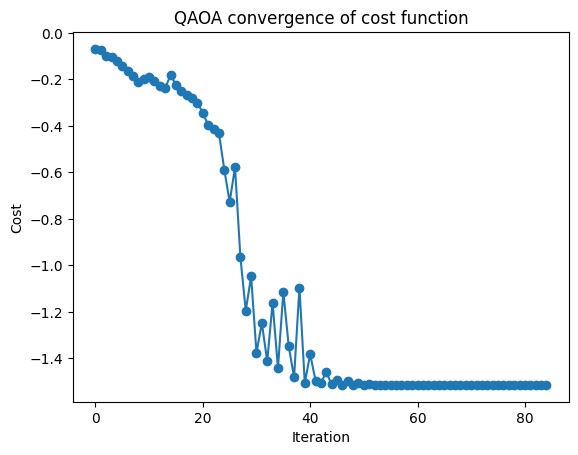

In [7]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(losses, "-o")
plt.ylabel("Cost")
plt.xlabel("Iteration")
plt.title("QAOA convergence of cost function")

In [8]:
print("Task Summary")
print(f"{tracker.quantum_tasks_statistics()} \n")
print(f"Estimated cost to run this example: {tracker.qpu_tasks_cost() + tracker.simulator_tasks_cost():.2f} USD")

Task Summary
{} 

Estimated cost to run this example: 0.00 USD


Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).